## Micro-pipelines inside Jupyter notebooks

[![](https://raw.githubusercontent.com/ploomber/ploomber/master/_static/open-in-jupyterlab.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fmicro-pipelines%252Fintroduction.ipynb%26branch%3Dmaster)

*Note: the micro-pipelines API was added in Ploomber 0.21*

Jupyter notebooks can get very [messy](https://ploomber.io/blog/clean-nbs/) due to many reasons: cells are executed out of order, data frames are modified, no modularity. Ploomber micro-pipelines are a more powerful version of [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

You can use Ploomber as a framework to write micro-pipelines that capture your data transformation logic enabling you to:

- Write cleaner code
- Re-use components
- Easily parallelize transformations
- Cache results

Let's see how this works:

## Transformations as functions

In [1]:
import pandas as pd

# the "root" transformations (tasks with no dependencies)
# need an input_data argument
def ones(input_data):
    return pd.Series(input_data)


# to use previous results, add names of
# other functions as arguments. For example,
# here, we'll use the output of "ones" as input
def twos(ones):
    return ones + 1


def both(ones, twos):
    return pd.DataFrame({"ones": ones, "twos": twos})


def final(both):
    both["final"] = both["ones"] + both["twos"] + 1
    return both

def one_more(ones):
    return ones + 1

## Creating the pipeline

To create the dag, pass the list of functions. Ploomber will automatically figure out the dependencies and execution order.

In the `params` argument, pass the input data for tasks that have no dependencies.

In [2]:
from ploomber.micro import dag_from_functions, grid, capture
from ploomber import InMemoryDAG

dag = dag_from_functions(
        [ones, twos, both, final, one_more],
        params={"ones": {"input_data": [1] * 100}},
        # store intermediate results in the cache/ directory
        output="cache"
    )

Note that `dag` is a regular Ploomber DAG so we have all the features:

- Incremental builds
- Debug later
- Parallelization, etc.

*Note:* To run tasks in parallel, pass `parallel=True`; however, parallel execution is in beta. If you encounter issues. [Let us know.](https://github.com/ploomber/ploomber/issues/new?title=problem%20with%20micro%20pipelines%20api)

## Plotting the pipeline

  0%|          | 0/5 [00:00<?, ?it/s]

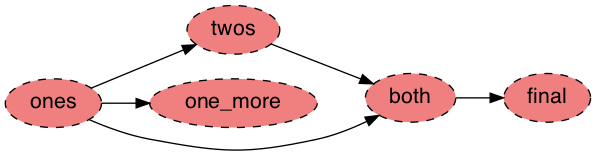

In [3]:
dag.plot()

## Executing the pipeline

In [4]:
dag.build()

  0%|          | 0/5 [00:00<?, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,True,0.002371,24.403
twos,True,0.001967,20.245
one_more,True,0.001091,11.2289
both,True,0.001936,19.9259
final,True,0.002351,24.1972


## Caching results

If we execute again, nothing will run since we have cached the results:

In [5]:
dag.build()

0it [00:00, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,False,0,0
twos,False,0,0
one_more,False,0,0
both,False,0,0
final,False,0,0


Now, modify one of the functions in the pipeline (and re-execute the cell, then come back and execute `.build()` again, you'll see that only affected tasks are executed:

In [6]:
dag.build()

0it [00:00, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,False,0,0
twos,False,0,0
one_more,False,0,0
both,False,0,0
final,False,0,0


## Loading outputs

Let's load the output of some task

In [7]:
dag["ones"].load().head(3)

0    1
1    1
2    1
dtype: int64

## In memory pipeline

`dag` serializes outputs for caching, this is useful for development. However, for production, you might want to convert into a full in-memory pipeline:

In [8]:
in_memory = InMemoryDAG(dag)

  0%|          | 0/5 [00:00<?, ?it/s]

To run it, pass a dictionary with the input data for tasks with no dependencies to `input_data`:

In [9]:
out = in_memory.build(input_data={"ones": [1] * 10})

`out` is a dictionary, where keys are task names and values are the outputs:

In [10]:
out["ones"].head(3)

0    1
1    1
2    1
dtype: int64

In [11]:
out["final"].head(3)

,ones,twos,final
0,1,2,4
1,1,2,4
2,1,2,4


Let's try with a different input value:

In [12]:
in_memory.build(input_data={"ones": [1.1] * 10})["final"].head(3)

,ones,twos,final
0,1.1,2.1,4.2
1,1.1,2.1,4.2
2,1.1,2.1,4.2


## Grid tasks (parametrization)

In some cases (for example, when training ML models), you might want to run the same function with grid of parameters, you can do so with the `@grid` decorator:

  0%|          | 0/4 [00:00<?, ?it/s]

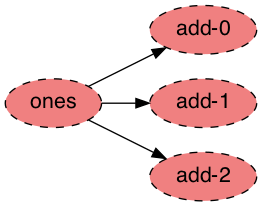

In [13]:
@grid(value=[0, 1, 2])
def add(ones, value):
    return ones + value

dag_grid = dag_from_functions(
    [ones, add],
    params={"ones": {"input_data": [1] * 100}},
    output="cache-grid",
    parallel=True,
)

dag_grid.plot()

You can check the parameter of each task:

In [14]:
print(dag_grid['add-0'].params['value'])
print(dag_grid['add-1'].params['value'])
print(dag_grid['add-2'].params['value'])

0
1
2


In [15]:
dag_grid.build()

  0%|          | 0/4 [00:00<?, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,True,0.004281,20.494
add-0,True,0.006348,30.3892
add-1,True,0.005218,24.9797
add-2,True,0.005042,24.1371


You can use more than one parameter in the `@grid`, the number of tasks will be the cartesian product:

  0%|          | 0/10 [00:00<?, ?it/s]

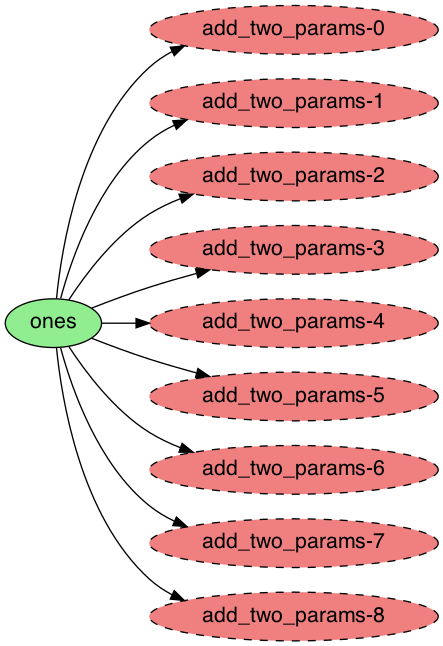

In [16]:
# generates: 3 * 3 = 9 tasks
@grid(value=[0, 1, 2], another=[3, 4, 5])
def add_two_params(ones, value, another):
    return ones + value + another

dag_grid_two = dag_from_functions(
    [ones, add_two_params],
    params={"ones": {"input_data": [1] * 100}},
    output="cache-grid",
    parallel=True,
)

dag_grid_two.plot()

You can also use the decorator more than once:

  0%|          | 0/19 [00:00<?, ?it/s]

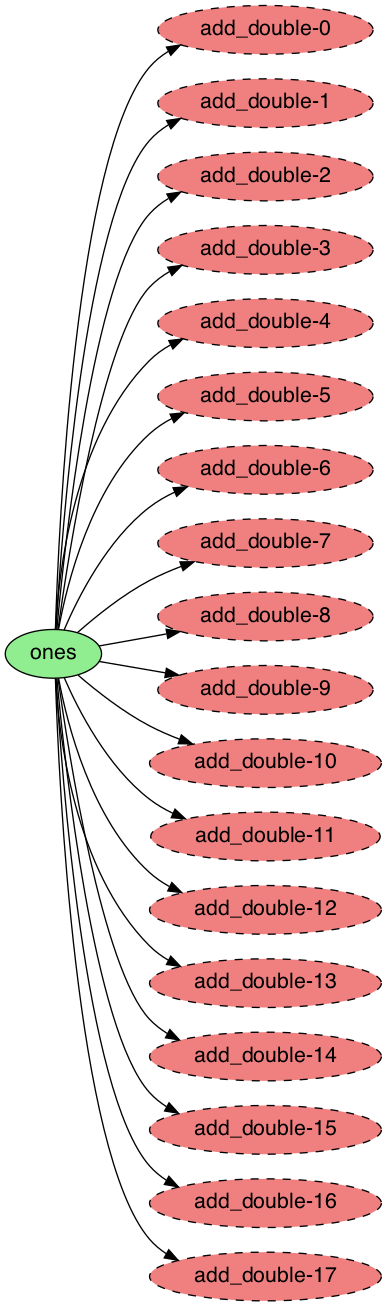

In [17]:
# generates:
# (3 * 3) + (3 * 3) = 18 tasks
@grid(value=[0, 1, 2], another=[3, 4, 5])
@grid(value=[6, 7, 8], another=[8, 10, 11])
def add_double(ones, value, another):
    return ones + value + another

dag_double = dag_from_functions(
    [ones, add_double],
    params={"ones": {"input_data": [1] * 100}},
    output="cache-grid",
    parallel=True,
)

dag_double.plot()

## Debugging

To debug a pipeline, you can use the `debug` argument when calling `dag.build()`:

In [18]:
def crashing(ones, twos):
    x, y = 1, 0
    return x / y


dag_debug = dag_from_functions(
    [ones, twos, crashing],
    params={"ones": {"input_data": [1] * 100}},
    output="cache-debugging",
    parallel=True,
)

  0%|          | 0/3 [00:00<?, ?it/s]

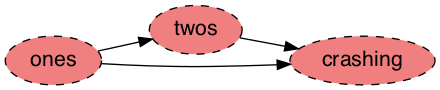

In [19]:
dag_debug.plot()

Start a debugging session as soon as the pipeline crashes:

```python
dag_debug.build(debug='now')
```

Serialize all tracebacks for later debugging:

```python
dag_debug.build(debug='later')
```

For more details, see the [debugging guide.](https://docs.ploomber.io/en/latest/user-guide/debugging.html)

## Re-using components

Your functions are re-usable, let's create a new pipeline by re-using two components and adding one more:

In [20]:
def multiply(ones, twos):
    df = pd.DataFrame({"mult": ones * twos})
    return df


dag_another = dag_from_functions(
    [ones, twos, multiply],
    output="cache-2",
    params={"ones": {"input_data": [1] * 100}},
    parallel=True,
)

  0%|          | 0/3 [00:00<?, ?it/s]

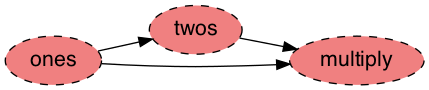

In [21]:
dag_another.plot()

In [22]:
dag_another.build()

  0%|          | 0/3 [00:00<?, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,True,0.004129,24.8391
twos,True,0.005314,31.9678
multiply,True,0.00718,43.1932


In [23]:
dag_another["multiply"].load().head(3)

,mult
0,2
1,2
2,2


## Writing generic components

Note that in the previous example, our `multiply` function had `ones` and `twos` as arguments. But what if we wanted to have a generic function like:

In [24]:
def multiply(first, second):
    return first * second

In this case, we can use the `dependencies` argument, to set the dependencies when the arguments do not match existing functions:

In [25]:
dag_generic = dag_from_functions(
    [ones, twos, multiply],
    output="cache-generic",
    params={"ones": {"input_data": [1] * 100}},
    # order matters:
    # output of "ones" -> "first"
    # output of "twos" -> "second"
    dependencies={"multiply": ["ones", "twos"]},
    parallel=True,
)

  0%|          | 0/3 [00:00<?, ?it/s]

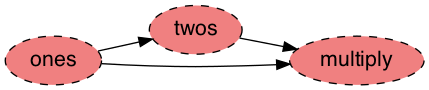

In [26]:
dag_generic.plot()

In [27]:
dag_generic.build(force=True)

  0%|          | 0/3 [00:00<?, ?it/s]

name,Ran?,Elapsed (s),Percentage
ones,True,0.004257,26.8411
twos,True,0.005309,33.4741
multiply,True,0.006294,39.6847


In [28]:
dag_generic["ones"].load().head(3)

0    1
1    1
2    1
dtype: int64

In [29]:
dag_generic["twos"].load().head(3)

0    2
1    2
2    2
dtype: int64

In [30]:
dag_generic["multiply"].load().head(3)

0    2
1    2
2    2
dtype: int64